In [1]:
# Import necessary libraries
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

In [14]:
class ArmedBanditsEnv():
    """
    num_expt -> number of experiments 
    num_slots -> available slots that can transmit data based on availablility
    p_values -> num_expts x num_slots matrix containing p-values for availability of slot
    action -> num_expts x num_slots array denoting the order of checking slots for availability for each expt
    """
    
    def __init__(self, p_values):
        assert len(p_values.shape) == 2
        
        self.num_slots = p_values.shape[1]
        self.num_expts = p_values.shape[0]
        self.state = np.zeros((self.num_expts,self.num_slots))
        
        self.p_values = p_values

    def generate_state(self):
        return np.random.binomial(n=1,p=self.p_values)
    
        
    def step(self, action_type, action, explore_type):
        
        # Sample from the specified slot using it's bernoulli distribution
        assert (action.shape == (self.num_expts,self.num_slots))
        
        sampled_state = np.random.binomial(n=1, p=self.p_values)

        self.state = sampled_state

        cost = np.zeros((self.num_expts, 1))

        for j in range(self.num_expts):
            # Get the relevant actions and their indices for the current experiment
            if action_type[j]==0 and explore_type[j]==1:
                cost[j]=self.num_slots
            else:
                actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
                relevant_states = sampled_state[j, actions]
                # Find the index of the first occurrence of 1, if any
                indices = np.where(relevant_states == 1)[0]
                if indices.size > 0:
                    first_one_index = indices[0]
                else:
                    first_one_index = len(actions)-1
                # Calculate the cost
                cost[j] = first_one_index+1
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        assert (cost.shape[1]==1)
        return cost,self.state, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsBernoulli(ArmedBanditsEnv):
    def __init__(self, num_expts=1, num_slots=5):
        self.p_values = np.random.uniform(0, 1, (num_expts, num_slots))
        
        ArmedBanditsEnv.__init__(self, self.p_values)

In [3]:
p_values = np.array([[0.1, 0.4, 0.2, 0.3]]) # The p_values for a four-slot channel. Single experiment

env = ArmedBanditsEnv(p_values) # Create the environment

for i in range(4):
    action = np.random.choice(range(1, 5), size=(1,4), replace=False)
    
    cost,state, _, _ = env.step([1],action,[1])
    print("State:",state ,"on Order:", action, " gave a cost of:",cost[0])

State: [[0 0 0 0]] on Order: [[1 2 3 4]]  gave a cost of: [4.]
State: [[0 0 0 0]] on Order: [[2 1 3 4]]  gave a cost of: [4.]
State: [[0 0 0 0]] on Order: [[2 4 1 3]]  gave a cost of: [4.]
State: [[0 0 1 0]] on Order: [[2 1 4 3]]  gave a cost of: [4.]


In [15]:
def inc_p(prev_p, new_val, n):
    return (prev_p*(n-1) + new_val)/n
inc_p_vect = np.vectorize(inc_p)


In [16]:
def greedy_order(estimates):
    """
    Takes in an array of estimates of num_expts x num_slots and returns the order
    of slots with the decreasing estimated p_value for each row. 
    Breaks ties randomly by introducing a small random noise.
    """
    if estimates.ndim == 1:
        sorted_indices = sort_with_noise(estimates)
    else:
        sorted_indices = np.apply_along_axis(sort_with_noise, 1, estimates)
    return sorted_indices

def random_ordering(estimates):
    """
    Takes in an array of estimates of num_expts x num_slots and returns the order
    of slots with the decreasing estimated p_value for each row.
    Breaks ties randomly by introducing a small random noise.
    """
    if estimates.ndim ==1:
        perm_index =random_order(estimates)
        
    else:
        perm_index = np.apply_along_axis(random_order, 1, estimates)
    return perm_index

def random_order(row):
    perm_index = np.random.permutation(len(row))
    
    return perm_index

def sort_with_noise(row):
    # Identifying unique values and their counts
    unique, counts = np.unique(row, return_counts=True)
    
    # Only add noise to elements where there are ties
    for value, count in zip(unique, counts):
        if count > 1:
            noise = np.random.normal(0, 1e-6, count)  # Small noise
            indices = row == value
            row[indices] += noise

    # Sort the indices after adding noise
    sorted_indices = np.argsort(-row) + 1
    return sorted_indices


In [6]:
estimates_1d = np.array([0.2, 0.2, 0.07, 0.1])
print(greedy_order(estimates_1d))

estimates_2d = np.array([[0.1, 0.3, 0.05, 0.2], [0.4, 0.2, 0.1, 0.3]])
print(greedy_order(estimates_2d))

[1 2 4 3]
[[2 4 1 3]
 [1 4 2 3]]


## Optimal Agent

In [9]:
class OptimalAgent():
    def __init__(self, p_values):
        
        # Store the epsilon value
        
        
        self.num_slots = p_values.shape[1]
        self.num_expts = p_values.shape[0]
        self.estimates = p_values.astype(np.float64)
        
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = np.tile([1],(self.num_expts,1))
        explore_type = np.tile([1],(self.num_expts,1)) 
        # Generate both types of actions for every experiment
        
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_order(p_values)
               
        return action_type,  action, explore_type
    
    def update_estimates(self, cost, state, action_type, action,explore_type):

        return 0
             
        

## THE GREEDY AGENT

It can be derived directly from greedy epsilon agent created later.

## Epsilon-Greedy Agent

In [10]:
class EpsilonGreedyAgent():
    def __init__(self, estimates, epsilon, delta):

        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        assert delta >= 0 and delta <= 1
        assert len(estimates.shape) == 2
        
        self.num_slots = estimates.shape[1]
        self.num_expts = estimates.shape[0]
        self.estimates = estimates.astype(np.float64)
        self.action_count = np.zeros(estimates.shape)
        self.epsilon = epsilon
        self.delta = delta
        
    
    def get_action(self):

        #epsilon is 1 for 100% greedy, delta is 0 for 100% full exploration
        action_type = (np.random.random_sample(self.num_expts) > self.epsilon).astype(int).reshape(-1,1)
        explore_type = (np.random.random_sample(self.num_expts) > self.delta).astype(int).reshape(-1,1)
        # Generate both types of actions for every experiment
        explore_full = np.tile(np.arange(1, self.num_slots + 1), (self.num_expts, 1))
        greedy_action = greedy_order(self.estimates)
        random_action = random_ordering(self.estimates)
        exploratory_action = explore_full*explore_type + random_action*(1-explore_type)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)

        # Action type = 1 => Greedy
        # Action type = 0 => explore
        # Explore type = 1 => explore full
        # Explore type = 0 => explore partially
        return action_type,action, explore_type
    
    def update_estimates(self, cost, state, action_type, action,explore_type):
        for j in range(self.num_expts):
            if action_type[j]==0 and explore_type[j]==1:
                # Increment action_count for all slots
                self.action_count[j] += 1
        
                # Apply the vectorized inc_p function to the entire row
                n = self.action_count[j]
                self.estimates[j] = inc_p(self.estimates[j], state[j], n)
            else:
                #print(self.estimates)
                num_expts, num_slots = action.shape

            
                c = int(cost[j][0])-1

                if c>0:
                    changed = action[j][:c]-1
                    
                    # Update the estimates and counts for the changed actions
                    self.action_count[j, changed] += 1
                    #print(self.action_count)
                    self.estimates[j, changed] = inc_p(self.estimates[j, changed], 0, self.action_count[j, changed])
                    #print(self.estimates)
                    

                # Update the estimates and counts for the not-changed action, if it exists
                slot = action[j][c]-1

                if c == num_slots-1:
                    self.action_count[j, slot] += 1
                    self.estimates[j, slot] = inc_p(self.estimates[j, slot], state[j,slot], self.action_count[j, slot])
                else :
                    self.action_count[j, slot] += 1
                    #print(self.action_count)
                    #print(self.action_count)
                    self.estimates[j, slot] = inc_p(self.estimates[j, slot], 1, self.action_count[j, slot])
                
             
        

In [9]:
agent = EpsilonGreedyAgent(np.array([[0,0,0,0]]),0,0)

cost = np.array([[1]])
state = np.array([[0,0,1,1]])
action_type = np.array([[1]])
explore_type = np.array([[1]])
action = np.array([[4,3,2,1]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[0,0,0,0]])
cost = np.array([[4]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)


state = np.array([[0,0,0,1]])
cost = np.array([[1]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[1,0,0,0]])
cost = np.array([[4]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)


[[0. 0. 0. 1.]]
[[0.  0.  0.  0.5]]
[[0.         0.         0.         0.66666667]]
[[0.5 0.  0.  0.5]]


In [10]:
agent = EpsilonGreedyAgent(np.array([[0,0]]),0,0)

cost = np.array([[2]])
state = np.array([[0,1]])
action_type = np.array([[1]])
action = np.array([[1,2]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[0,0]])
cost = np.array([[2]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[1,1]])
cost = np.array([[1]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[0,1]])
cost = np.array([[2]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)

state = np.array([[0,1]])
cost = np.array([[2]])

agent.update_estimates(cost,state,action_type,action,explore_type)
print(agent.estimates)


[[0. 1.]]
[[0.  0.5]]
[[0.33333333 0.5       ]]
[[0.25       0.66666667]]
[[0.2  0.75]]


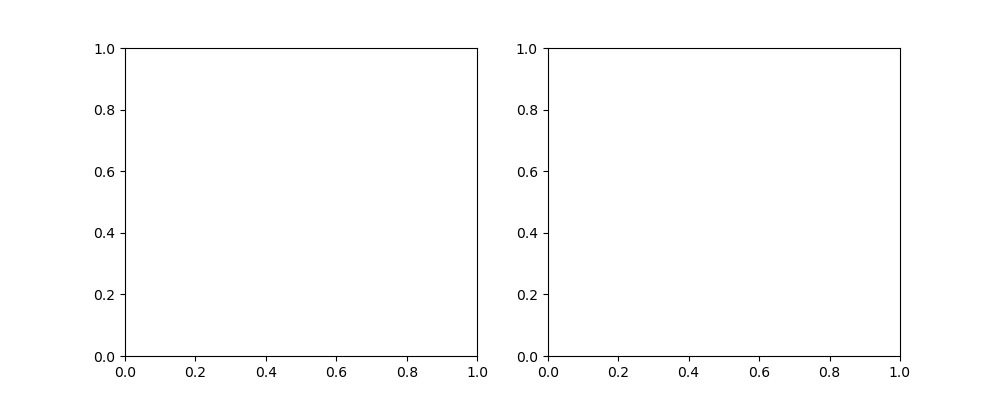

In [11]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0.1,0.9)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action,explore_type = agent.get_action()
    cost,state,_,_ = env.step(action_type,action,explore_type)
    agent.update_estimates(cost,state,action_type,action,explore_type)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()



Greedy agent is derived by taking epsilon as 0

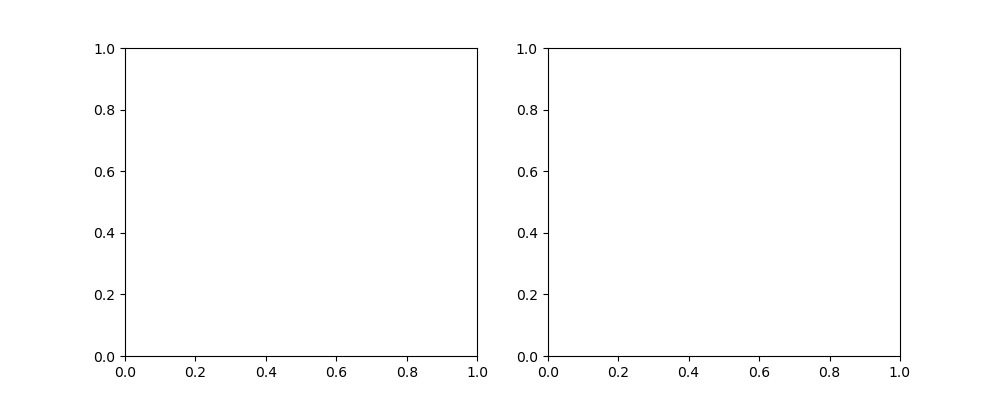

In [12]:
# Initialize environment and agent
num_expts = 2
num_slots = 5
num_steps = 100
p_values = np.random.rand(num_expts, num_slots)

env = ArmedBanditsEnv(p_values)
agent = EpsilonGreedyAgent(np.zeros((num_expts, num_slots)),0,1)

# Plotting setup
fig, axs = plt.subplots(1, num_expts, figsize=(10, 4))
x_pos = np.arange(num_slots)

def init():
    for i in range(num_expts):
        init_ax(i)

def init_ax(i):
    ax = axs if num_expts == 1 else axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_slots-.5)
    ax.set_xlabel('Slots', fontsize=14)
    ax.set_ylabel('P-Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.p_values[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

def step(g):
    action_type,action,explore_type = agent.get_action()
    cost,state,_,_ = env.step(action_type,action,explore_type)
    agent.update_estimates(cost,state,action_type,action,explore_type)
    for i in range(num_expts):
        ax = axs if num_expts == 1 else axs[i]
        # [Rest of the step function code]
        estimates = agent.estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()



## UCB AGENT

We need to implement the confidence interval along with the estimates for UCB

In [11]:
class UCBAgent():
    def __init__(self, estimates,radius, epsilon ,steps, delta):
        
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        assert len(estimates.shape) == 2
        assert delta >= 0 and delta <= 1
        self.num_slots = estimates.shape[1]
        self.num_expts = estimates.shape[0]
        self.estimates = estimates.astype(np.float64)
        self.radius = radius.astype(np.float64)
        self.action_count = np.zeros(estimates.shape)
        self.epsilon = epsilon
        self.total_steps = steps
        self.delta = delta
        
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_expts) > self.epsilon).astype(int).reshape(-1,1)
        explore_type = (np.random.random_sample(self.num_expts) > self.delta).astype(int).reshape(-1,1)
        # Generate both types of actions for every experiment
        explore_full = np.tile(np.arange(1, self.num_slots + 1), (self.num_expts, 1))
        greedy_action = greedy_order(self.estimates)
        random_action = random_ordering(self.estimates)
        exploratory_action = explore_full*explore_type + random_action*(1-explore_type)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        return action_type,  action, explore_type
    
    def update_estimates(self, cost, state, action_type, action, explore_type):
        for j in range(self.num_expts):
            if action_type[j]==0 and explore_type[j]==1:
                # Increment action_count for all slots
                self.action_count[j] += 1
        
                # Apply the vectorized inc_p function to the entire row
                n = self.action_count[j]
                self.estimates[j] = inc_p(self.estimates[j], state[j], n)
            else:

                num_expts, num_slots = action.shape

                c = int(cost[j][0])-1

                if c>0:
                    changed = action[j][:c]-1

                    # Update the estimates and counts for the changed actions
                    self.action_count[j, changed] += 1

                    self.estimates[j, changed] = inc_p(self.estimates[j, changed], 0, self.action_count[j, changed])

                # Update the estimates and counts for the not-changed action, if it exists
                slot = action[j][c]-1

                if c == num_slots-1:
                    self.action_count[j, slot] += 1
                    self.estimates[j, slot] = inc_p(self.estimates[j, slot], state[j,slot], self.action_count[j, slot])
                else :
                    self.action_count[j, slot] += 1
                    #print(self.action_count)
                    #print(self.action_count)
                    self.estimates[j, slot] = inc_p(self.estimates[j, slot], 1, self.action_count[j, slot])
                    
        zero_mask = self.action_count == 0
        non_zero_mask = ~zero_mask

        # Calculate radius for slots with non-zero action_count
        self.radius[non_zero_mask] = np.sqrt(2 * np.log(self.total_steps) / self.action_count[non_zero_mask])

        # Set radius to 0 for slots with zero action_count
        self.radius[zero_mask] = 0 
        

                
                
            

## Thomson Agent


In [23]:
class TSAgent():
    def __init__(self, alpha, beta):

        # Store the epsilon value
        alpha = alpha.astype(np.float64)
        beta = beta.astype(np.float64)
        
        assert len(alpha.shape) == 2
        assert len(beta.shape) == 2

        assert alpha.all()>0 and beta.all()>0

        self.num_slots = alpha.shape[1]
        self.num_expts = beta.shape[0]
        self.alpha = alpha.astype(np.float64)
        self.beta = beta.astype(np.float64)
        self.estimates = np.zeros(alpha.shape)
        self.action_count = np.zeros(alpha.shape)
        
    
    def get_action(self):

        sampled_estimates = np.random.beta(self.alpha,self.beta,self.alpha.shape)
        action = greedy_order(sampled_estimates)
        self.estimates = sampled_estimates

        return np.tile(1,(self.num_expts,1)),action ,np.tile(0,(self.num_expts,1))
    
    def update_estimates(self, cost, state, action_type, action,explore_type):
        for j in range(self.num_expts):
            #print(self.estimates)
            num_expts, num_slots = action.shape
        
            c = int(cost[j][0])-1
            if c>0:
                changed = action[j][:c]-1
                
                # Update the estimates and counts for the changed actions
                self.action_count[j, changed] += 1
                #print(self.action_count)
                self.beta[j, changed] += 1
                #print(self.estimates)
                
            # Update the estimates and counts for the not-changed action, if it exists
            slot = action[j][c]-1
            if c == num_slots-1:
                self.action_count[j, slot] += 1
                if state[j][slot]==1:
                    self.alpha[j, slot] += 1
                else:
                    self.beta[j,slot] +=1
            else :
                self.action_count[j, slot] += 1
                #print(self.action_count)
                #print(self.action_count)
                self.alpha[j, slot] += 1

            assert self.alpha.all()>0 and self.beta.all()>0
                
             
        

In [23]:
def give_Cost(num_expts,num_slots,sampled_state,action_type,action, explore_type):
        cost = np.zeros((num_expts, 1))

        for j in range(num_expts):
            # Get the relevant actions and their indices for the current experiment
            if action_type[j]==0 and explore_type[j]==1:
                cost[j]=num_slots
            else:
                actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
                relevant_states = sampled_state[j, actions]
                # Find the index of the first occurrence of 1, if any
                indices = np.where(relevant_states == 1)[0]
                if indices.size > 0:
                    first_one_index = indices[0]
                else:
                    first_one_index = len(actions)-1
                # Calculate the cost
                cost[j] = first_one_index+1
        return cost 

## Testing all the agents

In [13]:
class experiment():
    def __init__(self,agents,env,num_expts,num_slots,num_steps):
        self.agents = agents
        self.env = env
        self.num_expts = num_expts
        self.num_slots = num_slots
        self.num_steps = num_steps
        self.costs = {}
        self.estimates={}
        self.regret={}
        #self.give_Cost()
        #self.test_cost()
        self.agents["Optimal"] = OptimalAgent(self.env.p_values)
        for i,name in enumerate(agents.keys()):
            self.costs[name] = np.zeros((self.num_expts,self.num_steps+1))


    def give_Cost(self,num_expts,num_slots,sampled_state,action_type,action, explore_type):
        cost = np.zeros((num_expts, 1))

        for j in range(num_expts):
            # Get the relevant actions and their indices for the current experiment
            if action_type[j]==0 and explore_type[j]==1:
                cost[j]=num_slots
            else:
                actions = np.array(action[j]) - 1  # Adjust for zero-based indexing
                relevant_states = sampled_state[j, actions]
                # Find the index of the first occurrence of 1, if any
                indices = np.where(relevant_states == 1)[0]
                if indices.size > 0:
                    first_one_index = indices[0]
                else:
                    first_one_index = len(actions)-1
                # Calculate the cost
                cost[j] = first_one_index+1
        return cost 

    def test_cost(self,costs,step,agents,env):
        state = env.generate_state()
        
        num_expts = state.shape[0]
        num_slots = state.shape[1]
        
        for i,name in enumerate(agents.keys()):
            
            action_type,action,explore_type = agents[name].get_action()
            
            cost = self.give_Cost(num_expts,num_slots,state,action_type,action,explore_type)
            agents[name].update_estimates(cost,state,action_type,action,explore_type)
            costs[name][:,step+1] = costs[name][:,step] + cost.flatten()

        return costs,agents
    
    def run(self):
        
        for i in tqdm(range(self.num_steps)):
            self.costs,self.agents = self.test_cost(self.costs,i,self.agents,self.env)

        for i,name in enumerate(self.agents.keys()):
            self.estimates[name] = (self.agents[name].estimates).mean(axis=0)
            self.regret[name] = (self.costs[name] - self.costs["Optimal"]).mean(axis=0)

    
    def plot(self):
        plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
        
        for i,name in enumerate(self.agents.keys()):
            
            plt.plot(self.regret[name])

        plt.legend(self.agents.keys())
        plt.title(f"Testing algorithms on {self.num_steps} rounds over {self.num_slots} bandits")
        plt.ylabel(f"Avg Regret over {self.num_expts} realizations")
        plt.xlabel("Steps")
        plt.show()        


In [93]:
num_steps = 10000
num_expts = 10
num_slots = 2

probabilites = np.array([0.1,0.9])
p_values = np.tile(probabilites,(num_expts,1))

env = ArmedBanditsEnv(p_values)
delta = 0

agents = {
    "0.1eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1,delta),
    "UCB" : UCBAgent(np.zeros((num_expts,num_slots)),np.zeros((num_expts,num_slots)),0.1,num_steps,delta)

}
exp = experiment(agents,env,num_expts,num_slots,num_steps)
exp.run()

100%|██████████| 10000/10000 [00:08<00:00, 1226.14it/s]


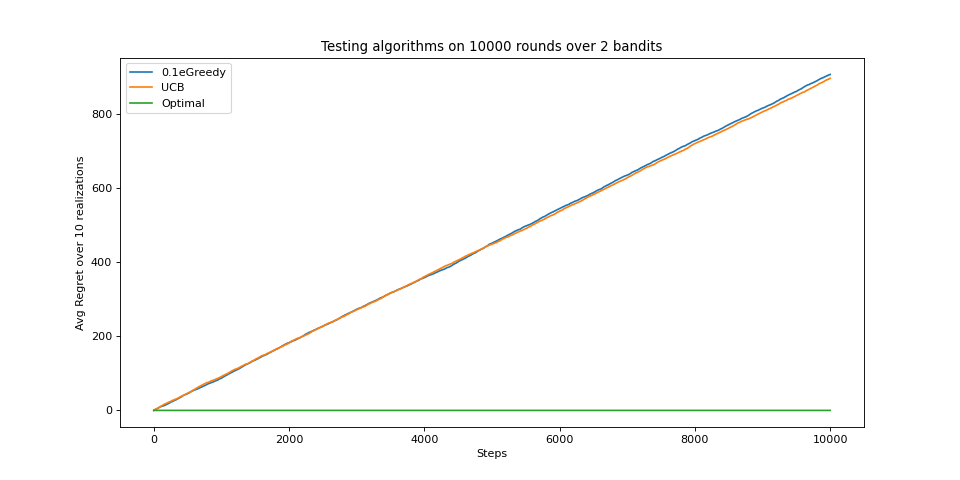

In [94]:
exp.plot()

In [95]:
plt.savefig('Update2/0.1,0.9bandits.png')

In [96]:
exp.estimates

{'0.1eGreedy': array([0.10078585, 0.89828698]),
 'UCB': array([0.0999203 , 0.89828898]),
 'Optimal': array([0.1, 0.9])}

In [46]:

num_steps = 10
num_expts = 10
num_slots = 6


probabilites = np.array([0.9,0.9,0.9,0.1,0.1,0.1])

p_values = np.tile(probabilites,(num_expts,1))

env = ArmedBanditsEnv(p_values)
delta = 0
agents = {
    "Greedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.0,delta)
}


exp = experiment(agents,env,num_expts,num_slots,num_steps)

exp.run()



100%|██████████| 10/10 [00:00<00:00, 1185.80it/s]


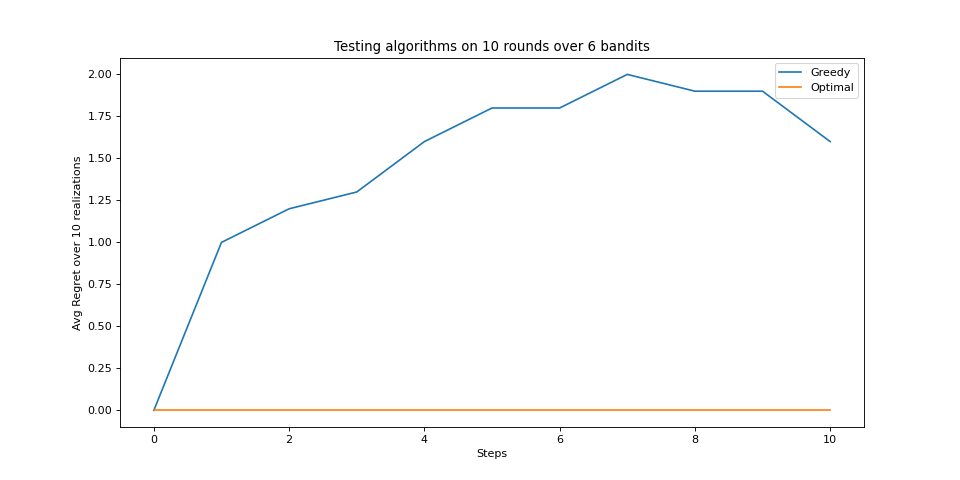

In [47]:
exp.plot()

In [48]:
exp.estimates['Greedy']

array([ 4.01666552e-01,  5.40991732e-01,  3.79999825e-01,  1.33333378e-01,
       -2.38447825e-07, -1.95963924e-07])

In [49]:
exp.regret['Greedy']

array([0. , 1. , 1.2, 1.3, 1.6, 1.8, 1.8, 2. , 1.9, 1.9, 1.6])

In [111]:

num_steps = 100
num_expts = 10
num_slots = 10


probabilites = np.array([0.9,0.9,0.9,0.9,0.9,0.1,0.1,0.1,0.1,0.1])

p_values = np.tile(probabilites,(num_expts,1))

env = ArmedBanditsEnv(p_values)
delta = 0
agents = {

    
    "0.1eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1,delta),
    "0.2eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.2,delta),
    "0.5eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.5,delta),
    "0.9eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.9,delta),
    #"Greedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.0,delta),
    "UCB" : UCBAgent(np.zeros((num_expts,num_slots)),np.zeros((num_expts,num_slots)),0.1,num_steps,delta)}



exp = experiment(agents,env,num_expts,num_slots,num_steps)

exp.run()



100%|██████████| 100/100 [00:00<00:00, 524.55it/s]


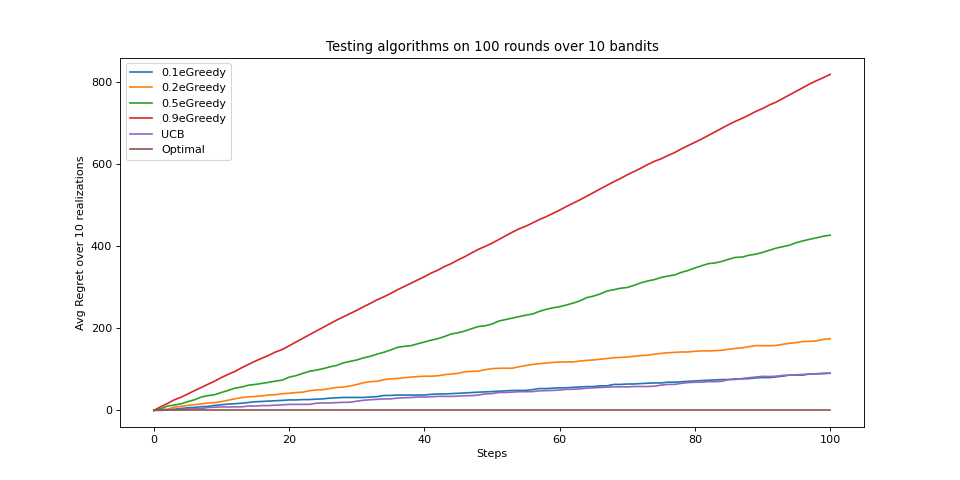

In [112]:
exp.plot()

In [114]:
plt.savefig('Update2/MultipleAlgos.png')

In [113]:
exp.estimates

{'0.1eGreedy': array([0.87725407, 0.86727665, 0.85115824, 0.87843158, 0.8877359 ,
        0.06206346, 0.1363492 , 0.06520198, 0.08380947, 0.11337111]),
 '0.2eGreedy': array([0.8566989 , 0.87473401, 0.88693501, 0.85596242, 0.90588003,
        0.11910393, 0.12172346, 0.13876156, 0.09937811, 0.06540346]),
 '0.5eGreedy': array([0.88733628, 0.89032231, 0.89882068, 0.89796734, 0.91479076,
        0.07739215, 0.10084611, 0.07988024, 0.08039939, 0.0956654 ]),
 '0.9eGreedy': array([0.89333743, 0.89386306, 0.89143877, 0.8946468 , 0.90934836,
        0.09227151, 0.0995848 , 0.09648275, 0.08286356, 0.092455  ]),
 'UCB': array([0.86405056, 0.80830982, 0.89496136, 0.86484449, 0.87654403,
        0.09787583, 0.06752227, 0.06756313, 0.06323078, 0.04366022]),
 'Optimal': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1])}

In [99]:
regrets = []
legends = []


In [108]:
num_slots = 20
num_steps = 10000
num_expts = 10
probabilites = np.arange(1,num_slots+1).astype(int)/(num_slots+1)
p_values = np.tile(probabilites,(num_expts,1))
env = ArmedBanditsEnv(p_values)
delta = 0
agents = {
    "UCB" : UCBAgent(np.zeros((num_expts,num_slots)),np.zeros((num_expts,num_slots)),0.1,num_steps,delta)}

exp = experiment(agents,env,num_expts,num_slots,num_steps)

exp.run()
regrets.append(exp.regret["UCB"]/num_slots)
egends.append(f"{num_slots}")



100%|██████████| 10000/10000 [00:05<00:00, 1762.33it/s]


In [ ]:
3,5,7,10,15,20

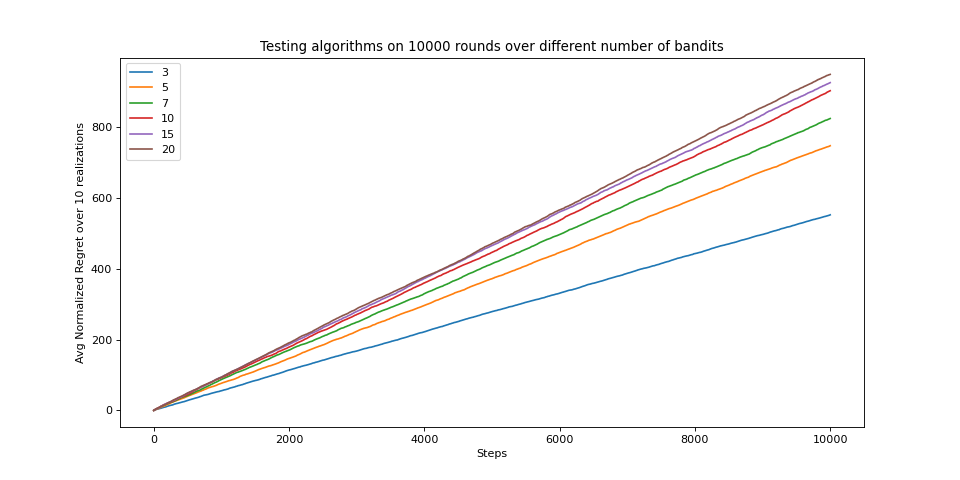

In [109]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
       
for i in range(len(regrets)):
    plt.plot(regrets[i])
plt.legend(legends)
plt.title(f"Testing algorithms on {num_steps} rounds over different number of bandits")
plt.ylabel(f"Avg Normalized Regret over {num_expts} realizations")
plt.xlabel("Steps")
plt.show() 

In [110]:
plt.savefig("Update2/VaryingBanditNum.png")

In [10]:
probabilites = 0.4+np.arange(1,11).astype(int)/100
print(probabilites)

[0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]


In [37]:
num_slots = 10
num_steps = 1000
num_expts = 10
probabilites = 0.4+np.arange(1,11).astype(int)/100
p_values = np.tile(probabilites,(num_expts,1))
env = ArmedBanditsEnv(p_values)
delta = 0
agents = {
    "UCB" : UCBAgent(np.zeros((num_expts,num_slots)),np.zeros((num_expts,num_slots)),0.1,num_steps,delta),
    "0.1eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1,delta)
    
    }

exp = experiment(agents,env,num_expts,num_slots,num_steps)

exp.run()




100%|██████████| 1000/1000 [00:00<00:00, 1053.87it/s]


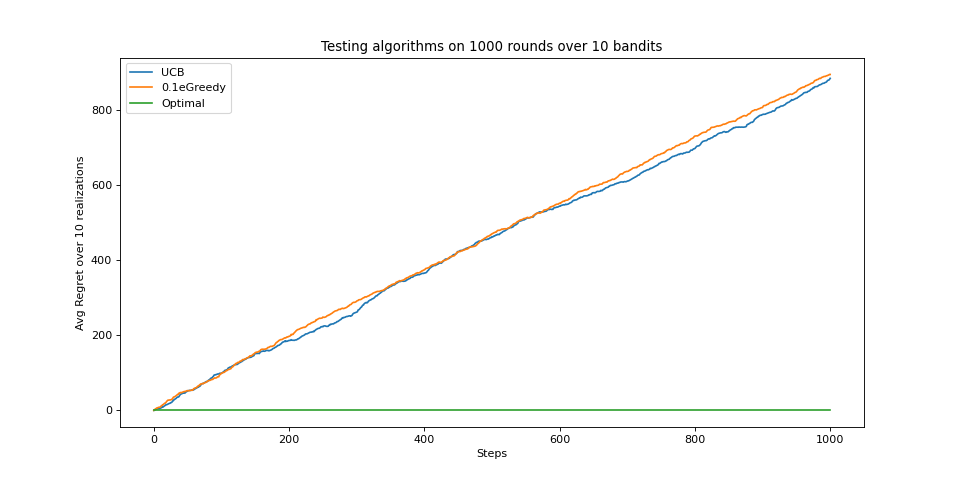

In [38]:
exp.plot()

In [35]:
exp.estimates

{'UCB': array([0.40700548, 0.42736848, 0.43018459, 0.42890827, 0.4450298 ,
        0.45732385, 0.46890295, 0.48130082, 0.48873008, 0.49919924]),
 '0.1eGreedy': array([0.41720443, 0.42150434, 0.43078275, 0.43469681, 0.44798026,
        0.45870514, 0.46819525, 0.48025595, 0.48984986, 0.50130296]),
 'Optimal': array([0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])}

In [40]:
plt.savefig('Update2/0.4-0.5,10bandits.png')

In [21]:

def cosine_similarity(arr1, arr2):
    """
    Compute the cosine similarity between two numpy arrays.

    Parameters:
    arr1 (np.array): First array
    arr2 (np.array): Second array

    Returns:
    float: Cosine similarity between arr1 and arr2
    """
    dot_product = np.dot(arr1, arr2)
    norm_arr1 = np.linalg.norm(arr1)
    norm_arr2 = np.linalg.norm(arr2)

    if norm_arr1 == 0 or norm_arr2 == 0:
        # Handling the case where one of the vectors is zero
        return 0.0
    
    cosine_sim = dot_product / (norm_arr1 * norm_arr2)
    return cosine_sim






In [39]:
print(cosine_similarity(exp.estimates['UCB'],exp.estimates['Optimal']))
print(cosine_similarity(exp.estimates['0.1eGreedy'],exp.estimates['Optimal']))


0.9999277553541077
0.9996959487730078


In [42]:
num_slots = 9
num_steps = 1000
num_expts = 10
probabilites = np.arange(1,10).astype(int)/10
p_values = np.tile(probabilites,(num_expts,1))
env = ArmedBanditsEnv(p_values)
delta = 0
agents = {
    "UCB" : UCBAgent(np.zeros((num_expts,num_slots)),np.zeros((num_expts,num_slots)),0.1,num_steps,delta),
    "0.1eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1,delta)
    
    }

exp = experiment(agents,env,num_expts,num_slots,num_steps)

exp.run()




100%|██████████| 1000/1000 [00:00<00:00, 1188.98it/s]


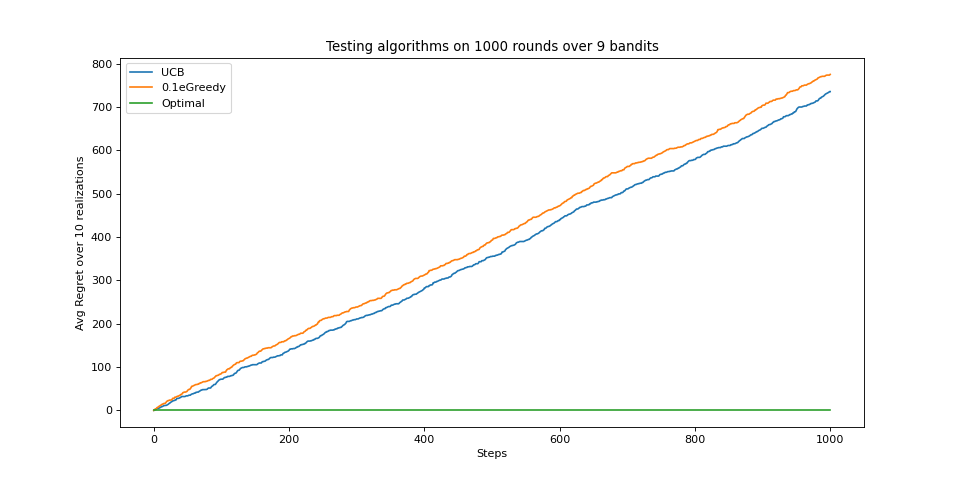

In [43]:
exp.plot()

In [44]:
exp.estimates

{'UCB': array([0.09069107, 0.1885291 , 0.27715821, 0.41240933, 0.47748233,
        0.58765882, 0.69889294, 0.78905506, 0.90745329]),
 '0.1eGreedy': array([0.09253079, 0.19049026, 0.26958192, 0.40268025, 0.51387506,
        0.57465308, 0.68200251, 0.79343794, 0.90807967]),
 'Optimal': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}

In [45]:
print(cosine_similarity(exp.estimates['UCB'],exp.estimates['Optimal']))
print(cosine_similarity(exp.estimates['0.1eGreedy'],exp.estimates['Optimal']))


0.9997352504324287
0.9996348500367074


In [46]:
plt.savefig('Update2/0.1-0.9,9bandits.png')

In [41]:
num_steps = 1000
num_expts = 100
num_slots = 2

probabilites = np.array([0.41,0.42])
p_values = np.tile(probabilites,(num_expts,1))

env = ArmedBanditsEnv(p_values)
delta = 0

agents = {
    "0.1eGreedy" : EpsilonGreedyAgent(np.zeros((num_expts,num_slots)),0.1,delta),
    "TS" : TSAgent(np.ones((num_expts,num_slots)),np.ones((num_expts,num_slots)))

}
exp = experiment(agents,env,num_expts,num_slots,num_steps)
exp.run()

100%|██████████| 1000/1000 [00:07<00:00, 130.49it/s]


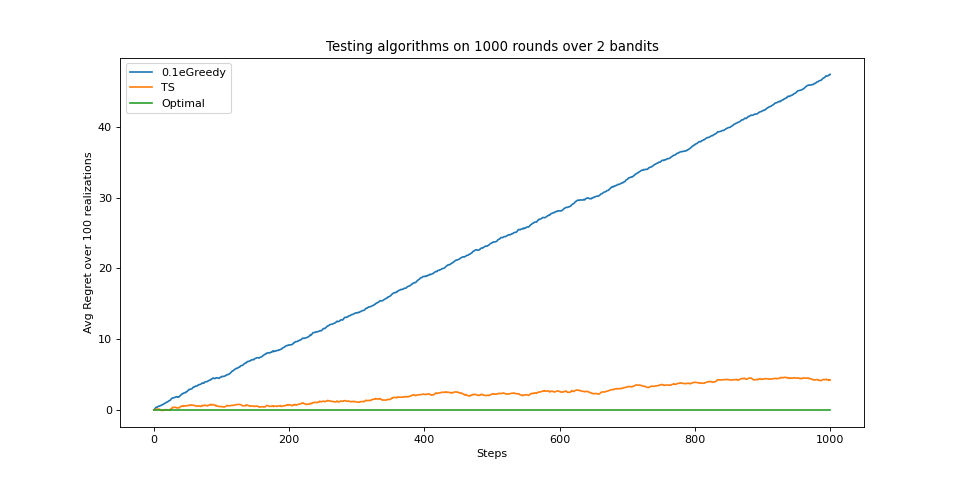

In [42]:
exp.plot()

In [43]:
exp.estimates

{'0.1eGreedy': array([0.40771834, 0.4197428 ]),
 'TS': array([0.40760165, 0.41822312]),
 'Optimal': array([0.41, 0.42])}

In [16]:
num_expts = 1
num_slots = 10

agent = TSAgent(np.ones((num_expts,num_slots)),np.ones((num_expts,num_slots)))

action_type,action,explore_type = agent.get_action()

env = ArmedBanditsBernoulli(num_expts,num_slots)





array([[0.21256082, 0.32731134, 0.35929712, 0.11496981, 0.55212   ,
        0.72988782, 0.5527682 , 0.40149245, 0.99810355, 0.06332436]])

In [28]:
class TS_UCBAgent():
    def __init__(self, alpha, beta, radius,m):

        # Store the epsilon value
        alpha = alpha.astype(np.float64)
        beta = beta.astype(np.float64)
        
        assert len(alpha.shape) == 2
        assert len(beta.shape) == 2

        assert alpha.all()>0 and beta.all() and radius.all()>0
        

        self.num_slots = alpha.shape[1]
        self.num_expts = beta.shape[0]
        self.alpha = alpha.astype(np.float64)
        self.beta = beta.astype(np.float64)
        self.estimates = np.zeros(alpha.shape)
        self.action_count = np.zeros(alpha.shape)
        self.radius = radius
        self.steps = 0
        self.sampling_num = self.m = m
        
    
    def get_action(self):

        sampled_estimates = np.zeros(self.alpha.shape).astype(np.float64)
        for i in range(self.m):
            sampled_estimates += np.random.beta(self.alpha,self.beta,self.alpha.shape).astype(np.float64)
        sampled_estimates /=self.m
        self.estimates = sampled_estimates

        mu = self.alpha/(self.alpha+self.beta)
        sampled_estimates = (sampled_estimates-mu)/self.radius
        action = greedy_order(sampled_estimates)
        

        return np.tile(1,(self.num_expts,1)),action ,np.tile(0,(self.num_expts,1))
    
    def update_estimates(self, cost, state, action_type, action,explore_type):
        for j in range(self.num_expts):
            #print(self.estimates)
            num_expts, num_slots = action.shape
        
            c = int(cost[j][0])-1
            if c>0:
                changed = action[j][:c]-1
                
                # Update the estimates and counts for the changed actions
                self.action_count[j, changed] += 1
                #print(self.action_count)
                self.beta[j, changed] += 1
                #print(self.estimates)
                
            # Update the estimates and counts for the not-changed action, if it exists
            slot = action[j][c]-1
            if c == num_slots-1:
                self.action_count[j, slot] += 1
                if state[j][slot]==1:
                    self.alpha[j, slot] += 1
                else:
                    self.beta[j,slot] +=1
            else :
                self.action_count[j, slot] += 1
                #print(self.action_count)
                #print(self.action_count)
                self.alpha[j, slot] += 1

            assert self.alpha.all()>0 and self.beta.all()>0
        self.steps+=self.num_slots
        zero_mask = self.action_count == 0
        non_zero_mask = ~zero_mask
        # Calculate radius for slots with non-zero action_count
        self.radius[non_zero_mask] = np.sqrt(2 * np.log(self.steps) / self.action_count[non_zero_mask])
        # Set radius to 0 for slots with zero action_count
        self.radius[zero_mask] = 1 
                
             
        

In [8]:
alpha = np.array([1,3])
beta = np.array([2,4])
mu = alpha/(alpha+beta)
mu

array([0.33333333, 0.42857143])

In [34]:
probabilites = np.array([0.1,0.9])
num_expts = 2
num_slots = 2
p_values = np.tile(probabilites,(num_expts,1))

env = ArmedBanditsEnv(p_values)
agent = TS_UCBAgent(np.ones((num_expts,num_slots)),np.ones((num_expts,num_slots)),np.ones((num_expts,num_slots)),10)



In [69]:
print(f"alpha : \n{agent.alpha} \nbeta : \n{agent.beta}")

action_type,action,explore_type = agent.get_action()

state = env.generate_state()

print(f"State : \n{state}")
print(f"Action : \n{action}")

cost = give_Cost(num_expts,num_slots,state,action_type,action,explore_type)
print(f"cost : \n{cost}")
agent.update_estimates(cost,state,action_type,action,explore_type)

print(f"alpha : \n{agent.alpha} \nbeta : \n{agent.beta}")
print(f"radius : \n{agent.radius}")
print(f"estimates : \n {agent.estimates}")

alpha : 
[[ 3. 29.]
 [ 4. 28.]] 
beta : 
[[21.  4.]
 [18.  4.]]
State : 
[[0 1]
 [0 1]]
Action : 
[[1 2]
 [2 1]]
cost : 
[[2.]
 [1.]]
alpha : 
[[ 3. 30.]
 [ 4. 29.]] 
beta : 
[[22.  4.]
 [18.  4.]]
radius : 
[[0.60573403 0.51353601]
 [0.64957738 0.52175311]]
estimates : 
 [[0.14506328 0.86552588]
 [0.15539049 0.8620662 ]]


In [37]:
print(agent.estimates)

[[0.47421315 0.61224356]
 [0.52914111 0.70434967]]
